<a href="https://colab.research.google.com/github/medbar/maga_sis/blob/main/2/DSSP/gcc_phat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import os
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
basedir='/content/drive/MyDrive/учебка/магистратура/2/ЦОРС/Курсовая/'

Mounted at /content/drive


In [ ]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)

In [ ]:
speech_speed    = 331 # м/с https://ru.wikipedia.org/wiki/Скорость_звука
mic_array_d = 0.05 # м
sr=16000

In [ ]:
test_signals = []

for fn in glob.glob(basedir+"/16sp*.wav"):
  print(fn)
  a, sr = librosa.load(fn, sr=sr)
  test_signals.append(a)

test_signals_lens = [len(s) for s in test_signals]
min_len = min(test_signals_lens)
test_signals = [s[:min_len] for s in test_signals]

/content/drive/MyDrive/учебка/магистратура/2/ЦОРС/Курсовая/16sp.wav
/content/drive/MyDrive/учебка/магистратура/2/ЦОРС/Курсовая/16spn_z2.wav


In [ ]:
for a in test_signals:
  player = ipd.Audio(a, rate=sr)
  ipd.display(player)

In [ ]:
mic_array = [None]*8

for fn in glob.glob(basedir+"/in*s.wav"):
  f_id = int(os.path.basename(fn)[2]) - 1
  a, sr = librosa.load(fn, sr=sr)
  mic_array[f_id] = a

In [ ]:
for a in mic_array:
  player = ipd.Audio(a, rate=sr)
  ipd.display(player)
  #draw_waveform(a, sr=sr)

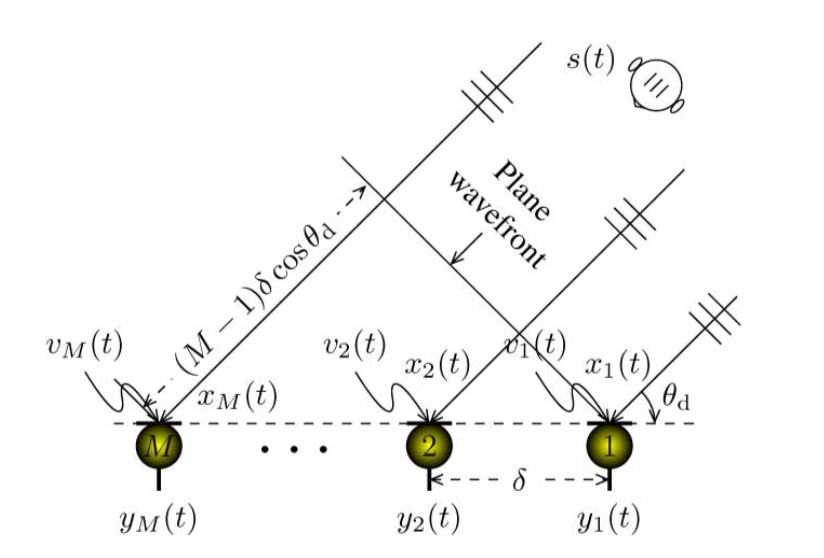

In [ ]:
def compute_angspect(coherence, distance_of_mic, num_tdoa):
    """
        coherence: num_bins x num_frames
        return num_tdoa x num_frames
    """
    # num_bins x num_toda
    num_bins, num_frames  = coherence.shape
    max_tdoa = distance_of_mic / speech_speed
    # from 0 to 180
    est_tdoa = np.linspace(-max_tdoa, max_tdoa, num_tdoa)
    sep_freq = np.linspace(0, sr / 2, num_bins)
    # num_tdoa x num_bins
    # inverse fourier transform
    exp_part = np.outer(2j * np.pi * est_tdoa, sep_freq)
    return np.dot(np.exp(exp_part), coherence).real

def GCC_PHAT(waves,distance_of_mic, win_length=1024, hop_length=256, num_tdoa=180, ):
    stft = [librosa.stft(wave, win_length=win_length, hop_length=hop_length) for wave in waves]
    #assert len(stft) == 2, 'Check pattern {} please'.format(args.pattern)
    # Generalized Cross-Correlation
    coherence = stft[0] * stft[1].conj() / (np.abs(stft[0]) * np.abs(stft[1])) 

    angspect = compute_angspect(coherence,distance_of_mic,  num_tdoa)
    angspect[angspect < 0] = 0
    plt.figure(figsize=(10,10))
    plt.ylabel('TDOA index')
    plt.xlabel('Frame index')
    plt.title('GCC-PATH Angular Spectrogram')
    plt.imshow(angspect, cmap=plt.cm.binary, aspect='auto', origin='lower')

    plt.show()
    Xdb = librosa.amplitude_to_db(abs(stft[0]))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.ylabel('Frequency index')
    plt.xlabel('Frame index')
    plt.title('Log-Magnitude Spectrogram')
    plt.show()
    return angspect

In [ ]:
def compute_angles(wavs, distance_of_mic, num_tdoa=120):
  angspec = GCC_PHAT(wavs, distance_of_mic, num_tdoa=num_tdoa)
  tau_coef = np.argmax(angspec, axis=0)
  plt.plot(range(len(tau_coef)), tau_coef)
  plt.xlabel("Frame")
  plt.ylabel("Argmax CC tau")
  plt.title("TDOA coefficients")
  plt.show()
  tau_meter = (tau_coef/num_tdoa-1)*distance_of_mic
  #plt.figure(figsize=(15,6))
  plt.grid(True)
  plt.plot(range(len(tau_meter)), tau_meter*100)
  plt.xlabel("Frame")
  plt.ylabel("Argmax CC tau")
  plt.title("TDOA (cm)")
  plt.show()

  # найдем угол
  alpha = tau_coef*180/num_tdoa-90
  plt.figure(figsize=(15,6))
  plt.grid(True)
  plt.plot(range(len(alpha)), alpha)#*90/np.pi)
  plt.xlabel("Кадры")
  plt.ylabel("градусы")
  plt.title("Угол прихода сигнала")
  plt.show()
  return alpha

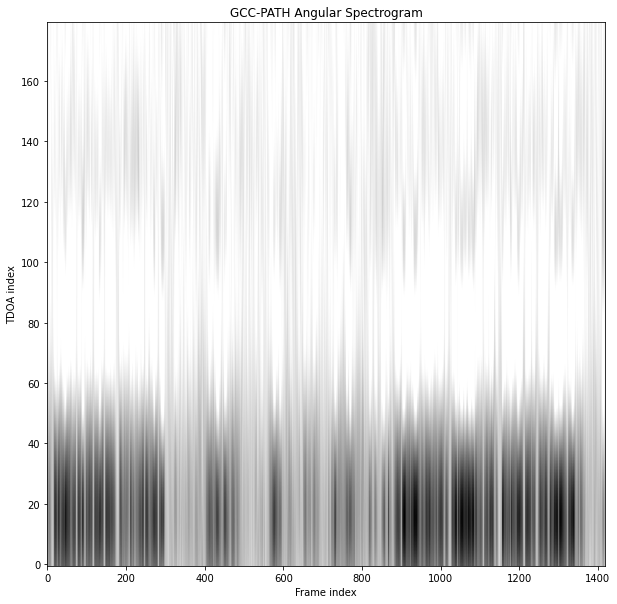

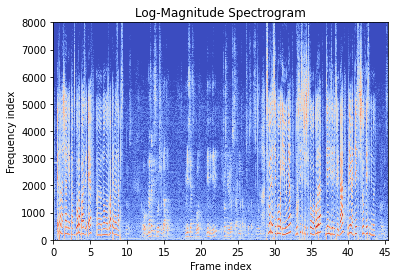

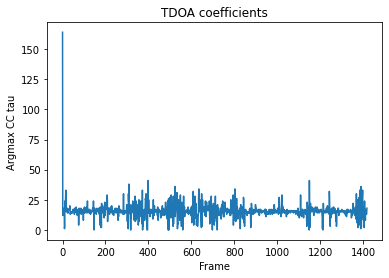

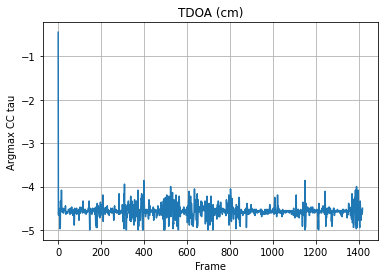

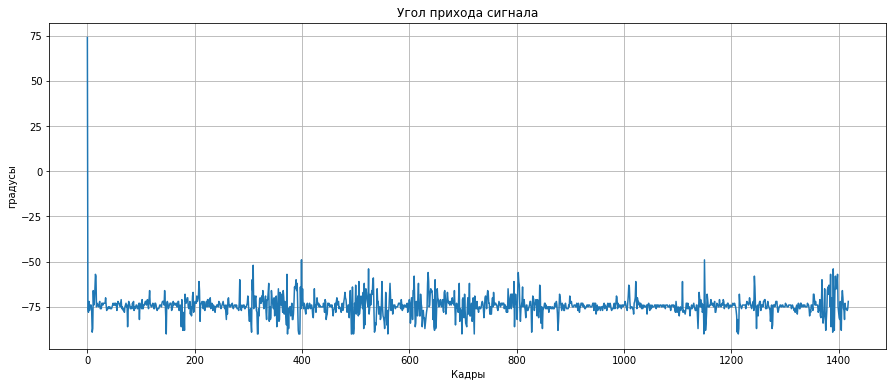

array([ 74., -76., -78., ..., -77., -76., -72.])

In [ ]:
compute_angles(test_signals, distance_of_mic=0.05, num_tdoa=180)

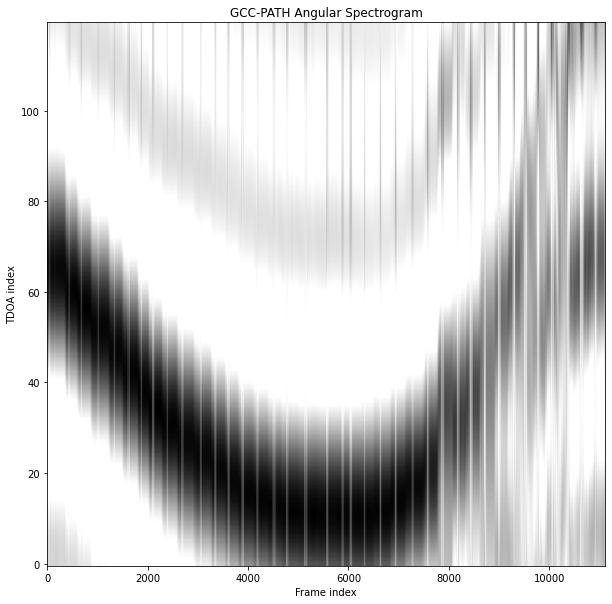

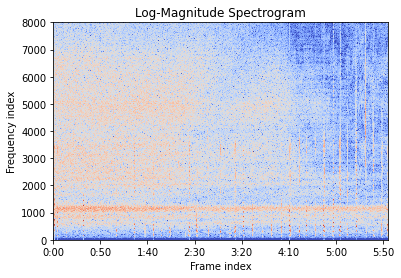

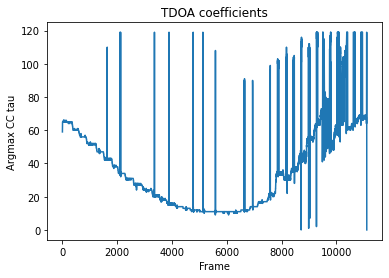

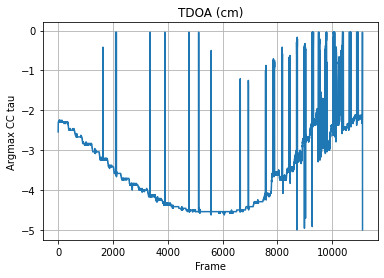

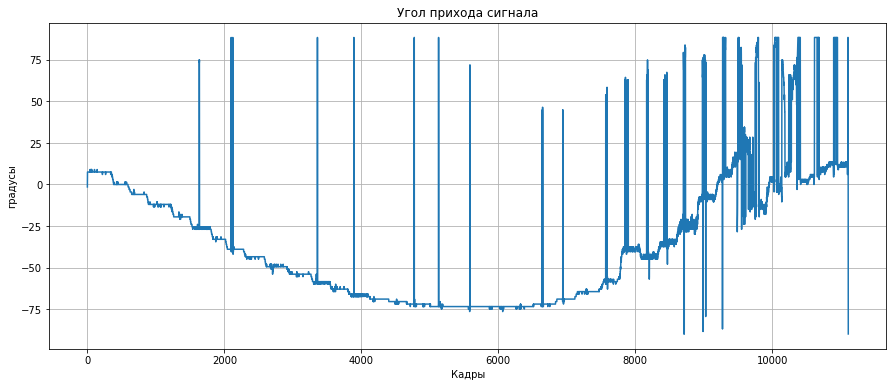

array([ -1.5,   6. ,   7.5, ...,  13.5,  12. , -90. ])

In [ ]:
compute_angles([mic_array[0], mic_array[7]], distance_of_mic=0.05*8)

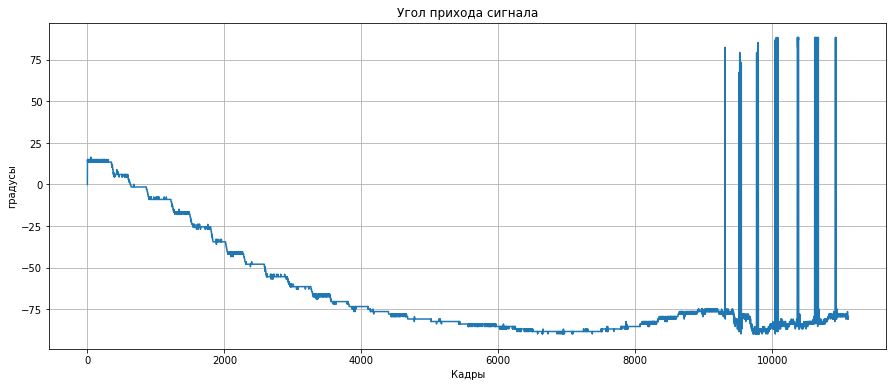

array([60, 70, 70, ...,  6,  6,  7])